In [1]:
import sys

sys.path.append("/homes/gf332/compression-without-quantization/code")

import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tf.keras
tfl = tf.keras.layers

from pln import AnalysisTransform_1, SynthesisTransform_1, AnalysisTransform_2, \
SynthesisTransform_2, ProbabilisticLadderNetwork, VariationalAutoEncoder

from miracle import create_dataset

import matplotlib.pyplot as plt
import numpy as np

tf.enable_eager_execution()

/scratch/gf332/compression_venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/gf332/compression_venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/gf332/compression_venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/scratch/gf332/compression_venv/lib/python3.5/site-pack

In [2]:
data_path = "/scratch/gf332/datasets/miracle_image_compression/train"
patch_size = 256
batch_size = 8
preprocess_threads = 1
likelihood = "gaussian"
learn_gamma = False

model_dir = "/scratch/gf332/cwoq-models/pln-test"

# ------------------------------------------------------------------------
# Load Dataset
# ------------------------------------------------------------------------
train_dataset = create_dataset(data_path, 
                               patch_size, 
                               batch_size, 
                               preprocess_threads)

num_pixels = batch_size * patch_size ** 2

# ------------------------------------------------------------------------
# Create Model and optimizer
# ------------------------------------------------------------------------
#     model = ProbabilisticLadderNetwork(first_level_filters=196,
#                                        second_level_filters=196,
#                                        first_level_latent_channels=128,
#                                        second_level_latent_channels=24,
#                                        likelihood=args.likelihood,
#                                        learn_gamma=args.learn_gamma)

model = VariationalAutoEncoder(num_filters=128,
                               num_latent_channels=128,
                               likelihood=likelihood,
                               learn_gamma=learn_gamma)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

# ------------------------------------------------------------------------
# Checkpoints
# ------------------------------------------------------------------------
global_step = tf.compat.v1.train.get_or_create_global_step()

checkpoint_prefix = model_dir + "/ckpt"
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model,
                                 optimizer_step=global_step)

manager = tf.train.CheckpointManager(checkpoint, checkpoint_prefix, max_to_keep=5)

checkpoint.restore(manager.latest_checkpoint)

if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from /scratch/gf332/cwoq-models/pln-test/ckpt/ckpt-2


(8, 256, 256, 3)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.9764706, shape=(), dtype=float32)
tf.Tensor(0.08159034, shape=(), dtype=float32)
tf.Tensor(0.7704665, shape=(), dtype=float32)
tf.Tensor(-186475.88, shape=(), dtype=float32)


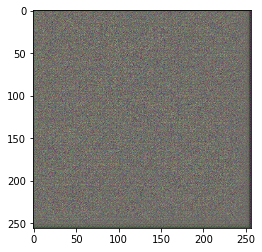

In [10]:
for batch in train_dataset.take(1):
    
    im = batch[3]
    
    plt.imshow(im)
    
    print(batch.shape)
    
    print(tf.reduce_min(im))
    print(tf.reduce_max(im))
    
    rec = model(batch[3:4])
    
    print(tf.reduce_min(rec))
    print(tf.reduce_max(rec))
    
    plt.imshow(rec[0])
    
    print(tf.reduce_sum(model.log_likelihood))